In [ ]:
!pip install tensorflow

In [ ]:
# -*- coding: utf-8 -*-

from tensorflow.keras.layers import Conv3D, ConvLSTM2D, Conv3DTranspose, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
import tensorflow as tf
from PIL import ImageFont, ImageDraw, Image
import numpy as np
import cv2
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import glob
import pickle
import os
import matplotlib.pyplot as plt

def BuildModel(input_shape=(227, 227, 50, 1)):
    input = Input(shape=input_shape)

    # Spatial Encoder
    spatial_enc = Conv3D(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(input)
    spatial_enc = BatchNormalization()(spatial_enc)
    spatial_enc = Activation('relu')(spatial_enc)
    spatial_enc = Conv3D(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(spatial_enc)
    spatial_enc = BatchNormalization()(spatial_enc)
    spatial_enc = Activation('relu')(spatial_enc)

    # Temporal Encoder
    temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.4, recurrent_dropout=0.3, return_sequences=True)(spatial_enc)
    temporal_enc = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.3, return_sequences=True)(temporal_enc)

    # Temporal Decoder
    temporal_dec = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', dropout=0.5, return_sequences=True)(temporal_enc)

    # Spatial Decoder
    spatial_dec = Conv3DTranspose(filters=64, kernel_size=(5,5,1), strides=(2,2,1), padding='valid')(temporal_dec)
    spatial_dec = BatchNormalization()(spatial_dec)
    spatial_dec = Activation('relu')(spatial_dec)
    spatial_dec = Conv3DTranspose(filters=128, kernel_size=(11,11,1), strides=(4,4,1), padding='valid')(spatial_dec)
    spatial_dec = BatchNormalization()(spatial_dec)
    spatial_dec = Activation('sigmoid')(spatial_dec)

    # Compiling Model
    autoencoder = Model(inputs=input, outputs=spatial_dec)
    encoder = Model(inputs=input, outputs=temporal_enc)

    # Decoder with consistent shape
    encoded_shape = encoder.output_shape[1:]
    encoded_input = Input(shape=encoded_shape)

    decoder_output = autoencoder.layers[-4](encoded_input)
    for layer in autoencoder.layers[-3:]:
        decoder_output = layer(decoder_output)
    decoder = Model(inputs=encoded_input, outputs=decoder_output)

    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])

    return autoencoder, encoder, decoder



def TF_GPUsetup(GB=4):
    if type(GB) != int:
        raise TypeError('Type of Parameter `GB` must be `int` and it should be 1 GB less than your GPU memory')
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.set_memory_growth(gpu, True)
            tf.config.set_virtual_device_configuration(
                gpus[0],
                [tf.config.VirtualDeviceConfiguration(memory_limit=1024 * GB)]
            )
            print(f"Configured to use up to {GB} GB of GPU memory.")
        except RuntimeError as e:
            print(e)
    print('\nTensorFlow GPU installed: ' + str(tf.test.is_built_with_cuda()))
    print('Is TensorFlow using GPU: ' + str(tf.config.list_physical_devices('GPU')))

def PrepareData(X_train, frame_count=50, height=227, width=227, channels=1):
    num_samples = X_train.shape[0]
    num_samples -= num_samples % frame_count
    X_train = X_train[:num_samples]
    X_train = X_train.reshape(-1, frame_count, height, width)
    X_train = np.transpose(X_train, (0, 2, 3, 1))
    X_train = np.expand_dims(X_train, axis=4)
    print("preparedataaaaaaaaaaaaaa ",X_train.shape)
    return X_train

def GetTrainData(name):
    if type(name) != str:
        raise TypeError('Provide a valid name of `string` datatype, to the `.npy` file.')
    if '.npy' not in name:
        name += '.npy'
    X_train = np.load(name)
    print("--------", X_train.ndim)
    print("------------", X_train.shape)
    return PrepareData(X_train)

def OverlayText2Img(img, text):
    cv2_im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im_rgb)
    draw = ImageDraw.Draw(pil_im)
    font = ImageFont.truetype("arial.ttf", 40)
    draw.text((0, 0), text, font=font)
    im_pros = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
    return im_pros

def ShowVideo(cap, v_frame, text):
    v_frame = OverlayText2Img(v_frame, text)
    cv2.imshow('Real Time Anomaly Detection - Github.com/irdanish11', v_frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        if cap is not None:
            cap.release()
        cv2.destroyAllWindows()
        raise KeyboardInterrupt('Real Time Anomaly Detection Stopped due to Keyboard Interrupt!')

def PrintInline(string):
    sys.stdout.write('\r' + string)
    sys.stdout.flush()

def ImgProcess(frame, shape=(227,227)):
    frame = cv2.resize(frame, shape)
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray = np.dot(frame, rgb_weights)
    gray = (gray - gray.mean()) / gray.std()
    gray = np.clip(gray, 0, 1)
    return gray

def Img_LstArr(img_lst, re_shape=(227, 227, 10)):
    img_arr = np.array(img_lst)
    img_arr.resize(re_shape)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = np.expand_dims(img_arr, axis=4)
    return img_arr

def MSE(x1, x2):
    diff = x1 - x2
    a, b, c, d, e = diff.shape
    n_samples = a * b * c * d * e
    sq_diff = diff ** 2
    Sum = sq_diff.sum()
    dist = np.sqrt(Sum)
    mean_dist = dist / n_samples
    return mean_dist

def ListCopy(lst):
    new_lst = []
    for item_lst in lst:
        for item in item_lst:
            new_lst.append(item)
    return new_lst

def TrainModel(X_train, autoencoder_model, encoder_model, decoder_model, ckpt_name, hist_name, ckpt_path, epochs, batch_size):
    os.makedirs(ckpt_path, exist_ok=True)
    ckpt = ModelCheckpoint(os.path.join(ckpt_path, ckpt_name), monitor='loss', save_best_only=True)
    e_stop = EarlyStopping(monitor='loss', patience=10)
    History = autoencoder_model.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, callbacks=[ckpt, e_stop])
    encoder_model.save_weights(os.path.join(ckpt_path, 'encoder_weights.weights.h5'))
    decoder_model.save_weights(os.path.join(ckpt_path, 'decoder_weights.weights.h5'))
    with open(os.path.join(ckpt_path, hist_name), "wb") as f:
        pickle.dump(History.history, f)
    return History.history


def DisplayFrames(X_train):
    # Remove the batch dimension and the channel dimension
    X_train = X_train[0, :, :, :, 0]

    num_frames = X_train.shape[2]
    fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 2, 2))

    for i in range(num_frames):
        ax = axes[i]
        ax.imshow(X_train[:, :, i], cmap='gray')
        ax.axis('off')  # Hide the axes

    plt.show()

def LoadModelWeights(encoder_model, decoder_model, ckpt_path):
    encoder_model.load_weights(os.path.join(ckpt_path, 'encoder_weights.weights.h5'))
    decoder_model.load_weights(os.path.join(ckpt_path, 'decoder_weights.weights.h5'))

def EncodeData(encoder_model, input_data):
    return encoder_model.predict(input_data)

def DecodeData(decoder_model, encoded_data):
    return decoder_model.predict(encoded_data)

def TestModel(encoder_model, decoder_model, test_data):
    encoded_data = EncodeData(encoder_model, test_data)
    reconstructed_data = DecodeData(decoder_model, encoded_data)
    return reconstructed_data

if __name__ == "__main__":
    input_shape = (227, 227, 50, 1)
    X_train = GetTrainData("/content/drive/MyDrive/Avenue_Dataset/Train_Data/normalized_batch_0.npy")
    # DisplayFrames(X_train)
    autoencoder_model, encoder_model, decoder_model = BuildModel(input_shape)

    ckpt_name = "autoencoder_checkpoint.keras"
    hist_name = "training_history.pkl"
    ckpt_path = "./checkpoints"
    epochs = 50
    batch_size = 2

    TrainModel(X_train, autoencoder_model, encoder_model, decoder_model, ckpt_name, hist_name, ckpt_path, epochs, batch_size)

    # Load the encoder and decoder weights
    LoadModelWeights(encoder_model, decoder_model, ckpt_path)

    # Test the model with new data
    test_data = GetTrainData("/content/drive/MyDrive/Avenue_Dataset/Train_Data/normalized_batch_0.npy")

    # Check the encoder output shape
    encoded_output = EncodeData(encoder_model, test_data)
    print(f"Encoder output shape: {encoded_output.shape}")

    # # Decode the encoded output
    # reconstructed_data = DecodeData(decoder_model, encoded_output)
    # print("Reconstructed data shape:", reconstructed_data.shape)


-------- 3
------------ (50, 227, 227)
preparedataaaaaaaaaaaaaa  (1, 227, 227, 50, 1)
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 88s 88s/step - accuracy: 0.0040 - loss: 0.2498
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0039 - loss: 0.2396
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0044 - loss: 0.2295
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0051 - loss: 0.2187   
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0053 - loss: 0.2074   
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0059 - loss: 0.1957   
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 0.0067 - loss: 0.1843
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0072 - loss: 0.1742   
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0073 - loss: 0.1662
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0075 - loss: 0.1598   
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0078 - loss: 0.1546  

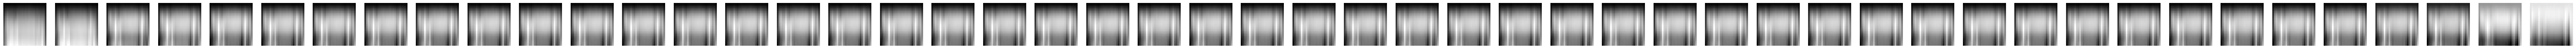

In [ ]:
DisplayFrames(encoded_output)

In [ ]:


cover_image = Image.open('/content/0001.png')
cover_array = np.array(cover_image)

# Step 3: Normalize the latent representation
latent_representation_normalized = (encoded_output - np.min(encoded_output)) / (np.max(encoded_output) - np.min(encoded_output)) * 255
latent_representation_normalized = latent_representation_normalized.astype(np.uint8)

# Reshape the latent representation to fit the cover image dimensions
latent_representation_resized = np.resize(latent_representation_normalized, (cover_array.shape[0], cover_array.shape[1], 64))

# Step 4: Transform the latent representation (optional)
# Here, you can apply any transformation. For simplicity, we will skip this step.

# Step 5: Blend the latent representation with the cover image
blending_factor = 0.1  # Adjust this factor to control visibility
embedded_image = cover_array * (1 - blending_factor) + latent_representation_resized * blending_factor
embedded_image = np.clip(embedded_image, 0, 255).astype(np.uint8)

# Step 6: Save the embedded image
embedded_image_pil = Image.fromarray(embedded_image)
embedded_image_pil.save('output.png')

ValueError: operands could not be broadcast together with shapes (1404,2040,3) (1404,2040,64) 